# Basic spectrogram image classification with Basic Audio Data Augmentation for G2Net.

Code modified from JUN KODA's [Basic spectrogram image classification](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification).
In addition, I'll introduce some basic audio data augmentations for G2Net.

In [1]:
 COLAB = False

if COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Colab Notebooks/kaggle/G2Net2022/code'

In [2]:
! pip3 install timm -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as TF


from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler

device = torch.device('cuda')
criterion = nn.BCEWithLogitsLoss()

# Train metadata
di = '../input/g2net-detecting-continuous-gravitational-waves'
df = pd.read_csv(di + '/train_labels.csv')
df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)

# Dataset

In [4]:
transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )

transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )

flip_rate = 0.0 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 0.0 # probability of applying the vertical shift

time_mask_num = 0 # number of time masking
freq_mask_num = 0 # number of frequency masking

In [5]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df, tfms=False):
        self.data_type = data_type
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = p

        if self.tfms:
            if np.random.rand() <= flip_rate: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= flip_rate: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= fre_shift_rate: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(time_mask_num): # tima masking
                img = transforms_time_mask(img)
            for _ in range(freq_mask_num): # frequency masking
                img = transforms_freq_mask(img)
        
        else:
            img = torch.from_numpy(img)
                
        return img, y

# Audio Data Augmentation for G2Net.

* horizontal flip
* vertical flip
* vertical shift
* time masking*
* frequency masking*

*Reference  
SpecAugment  
https://arxiv.org/abs/1904.08779

## Horizontal flip and Vertical flip 

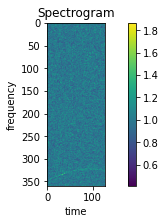

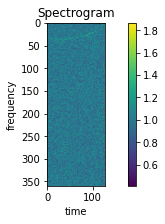

In [6]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()


flip_rate = 1.0 # probability of applying the horizontal flip and vertical flip 

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()

## Vertical shift

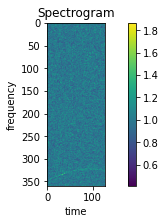

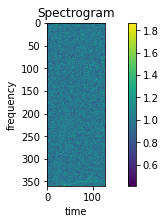

In [7]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()


flip_rate = 0.0 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 1.0 # probability of applying the vertical shift

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()

## Time masking

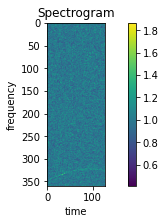

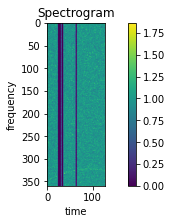

In [8]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()


flip_rate = 0.0 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 0.0 # probability of applying the vertical shift
time_mask_num = 3 # number of time masking

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()

## Frequency masking

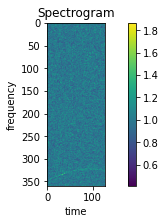

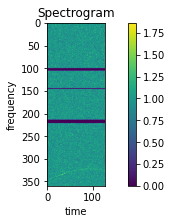

In [9]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()


flip_rate = 0.0 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 0.0 # probability of applying the vertical shift
time_mask_num = 0 # number of time masking
freq_mask_num = 3 # number of frequency masking

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 0:360])
plt.colorbar()
plt.show()

# Model

In [10]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.fc = nn.Linear(n_features, 1)
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

# Predict and evaluate

In [11]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)

        with torch.no_grad():
                y_pred = model(img.to(device))

        loss = criterion(y_pred.view(-1), y)

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del loss, y_pred, img, y

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary

    return ret

# Train

In [12]:
model_name = 'tf_efficientnet_b6_ns'
nfold = 5
kfold = KFold(n_splits=nfold, random_state=42, shuffle=True)

epochs = 25
batch_size = 32
num_workers = 2
weight_decay = 1e-6
max_grad_norm = 1000

lr_max = 4e-4
epochs_warmup = 1.0


## setting of audio data augmentation 
flip_rate = 0.5 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 1.0 # probability of applying the vertical shift
time_mask_num = 1 # number of time masking
freq_mask_num = 2 # number of frequency masking

for ifold, (idx_train, idx_test) in enumerate(kfold.split(df)):
    print('Fold %d/%d' % (ifold, nfold))
    torch.manual_seed(42 + ifold + 1)

    # Train - val split
    dataset_train = Dataset('train', df.iloc[idx_train], tfms=True)
    dataset_val = Dataset('train', df.iloc[idx_test])

    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True, shuffle=True, drop_last=True)
    loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True)

    # Model and optimizer
    model = Model(model_name, pretrained=True)
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

    # Learning-rate schedule
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # number of warmup steps
    nsteps = epochs * nbatch        # number of total steps

    scheduler = CosineLRScheduler(optimizer,
                  warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
                  t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine
    
    time_val = 0.0
    lrs = []

    tb = time.time()
    print('Epoch   loss          score   lr')
    for iepoch in range(epochs):
        loss_sum = 0.0
        n_sum = 0

        # Train
        for ibatch, (img, y) in enumerate(loader_train):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(img)
            loss = criterion(y_pred.view(-1), y)

            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       max_grad_norm)
            optimizer.step()
            
            scheduler.step(iepoch * nbatch + ibatch + 1)
            lrs.append(optimizer.param_groups[0]['lr'])            

        # Evaluate
        val = evaluate(model, loader_val)
        time_val += val['time']
        loss_train = loss_sum / n_sum
        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time() - tb) / 60
        print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))

    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))

    # Save model
    ofilename = 'model%d.pytorch' % ifold
    torch.save(model.state_dict(), ofilename)
    print(ofilename, 'written')

#     break  # 1 fold only

Fold 0/5


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_ns-51548356.pth


Epoch   loss          score   lr
Epoch 1 0.6434 0.6465 0.5489  4.00e-04  1.79 min
Epoch 2 0.6149 0.5606 0.6170  3.98e-04  3.60 min
Epoch 3 0.5675 0.5394 0.7053  3.93e-04  5.41 min
Epoch 4 0.5596 0.5785 0.6885  3.85e-04  7.20 min
Epoch 5 0.5354 0.4960 0.7072  3.73e-04  9.05 min
Epoch 6 0.5136 0.4944 0.7790  3.59e-04  10.89 min
Epoch 7 0.5059 0.5332 0.7787  3.42e-04  12.73 min
Epoch 8 0.5119 0.4973 0.7695  3.22e-04  14.58 min
Epoch 9 0.4989 0.5034 0.7563  3.00e-04  16.44 min
Epoch 10 0.4856 0.5238 0.7401  2.77e-04  18.30 min
Epoch 11 0.5049 0.4854 0.7274  2.52e-04  20.14 min
Epoch 12 0.4855 0.4945 0.7312  2.27e-04  21.97 min
Epoch 13 0.4984 0.4977 0.7328  2.00e-04  23.77 min
Epoch 14 0.4872 0.4866 0.7303  1.74e-04  25.59 min
Epoch 15 0.4690 0.4859 0.7123  1.49e-04  27.41 min
Epoch 16 0.4655 0.4969 0.7135  1.24e-04  29.23 min
Epoch 17 0.4637 0.4950 0.7154  1.01e-04  31.06 min
Epoch 18 0.4711 0.4949 0.7088  7.91e-05  32.90 min
Epoch 19 0.4603 0.5176 0.6983  5.94e-05  34.75 min
Epoch 20 0.4

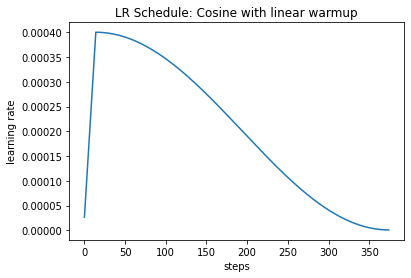

In [13]:
plt.title('LR Schedule: Cosine with linear warmup')
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.plot(lrs)
plt.show()

# Predict and submit

In [14]:
submit = pd.read_csv(di + '/sample_submission.csv')
if COLAB == False:
    # Load model (if necessary)
    
    submit['target'] = 0
    for i in range(5):
        model = Model(model_name, pretrained=False)
        filename = f'model{i}.pytorch'
        model.to(device)
        model.load_state_dict(torch.load(filename, map_location=device))
        model.eval()

        # Predict
        dataset_test = Dataset('test', submit)
        loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                                num_workers=num_workers, pin_memory=True)

        test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))

        # Write prediction
        submit['target'] += test['y_pred']/5
submit.to_csv('submission-5folds.csv', index=False)
print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

target range [0.39, 1.00]
